In [ ]:
#| default_exp index

In [ ]:
#| hide
#| export
import pandas as pd
import numpy as np
from cylinder.demand import load_demand
from cylinder.power import load_power
from cylinder.hwc import HWC
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

This file will become your README and also the index of your documentation.

## Install

```sh
pip install cylinder
```

This basic model provides the core function for a step change calculation in a mixed hot water cylinder

## How to use

Load some data that can be used to test the model - flow and electricity pricing

In [ ]:
df = (pd.DataFrame(load_demand(path = Path('../data/drawprofiles'),bed=5,unit=4)))
df.columns=["flow"]
df = df.merge(load_power(path = Path('../data')), how='left', left_index=True, right_index=True)
df.head()

,flow,price,price_kw,date,week,hour,day,peak,tou,cost,n_cost,sr_cost,lr_cost
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,7.920,0.007920,2020-01-01,1,0,2,0,0.02,0.027920,-0.22080,0.162438,0.149272
2020-01-01 00:01:00,0.0,8.526,0.008526,2020-01-01,1,0,2,0,0.02,0.028526,-0.21474,0.158675,0.145694
2020-01-01 00:02:00,0.0,9.132,0.009132,2020-01-01,1,0,2,0,0.02,0.029132,-0.20868,0.155010,0.142235
2020-01-01 00:03:00,0.0,9.738,0.009738,2020-01-01,1,0,2,0,0.02,0.029738,-0.20262,0.151437,0.138888
2020-01-01 00:04:00,0.0,10.344,0.010344,2020-01-01,1,0,2,0,0.02,0.030344,-0.19656,0.147952,0.135645


Create a hot water cylinder object and initialise it with the data 

In [ ]:
hwc = HWC(T_set=70, T_deadband=2, element=3, radius=.2, height=1.5)

In [ ]:
print(f'The HWC volume is {int(hwc.volume*1000)} liters')
print(f'The HWC surface area is {hwc.surface_area:.2f} m2')
print(f'The HWC has a {hwc.element:.2f} kW element')


The HWC volume is 188 liters
The HWC surface area is 2.14 m2
The HWC has a 3.00 kW element


Default thermogram 

<matplotlib.image.AxesImage>

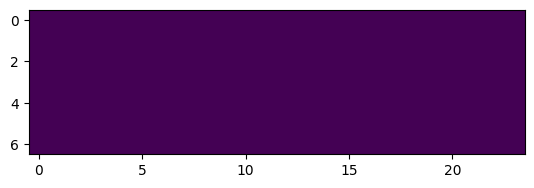

In [ ]:
plt.imshow(hwc.thermogram)

Run the model for a single day on thermostat and plot the results

In [ ]:
hwc = HWC(T_set=55, T_deadband=1.2, element=3, radius=.2, height=1.5)

In [ ]:
results = []

for index, row in df.loc['2020-01-03'].iterrows():
  raw_flow = row['flow']
  hwc.flow = raw_flow*(hwc.T_demand-hwc.T_cold)/(hwc.T-hwc.T_cold) 
  # print(raw_flow,hwc.flow)
  hwc._thermostat()
  hwc.T = hwc._update_temperatures(action=1)
  results.append([index,hwc.T, hwc.thermostat, hwc.flow,row.cost])
  r,c = row.day, row.hour
  hwc.thermogram[r,c] = hwc.thermostat * 1 * hwc.Qi /60 + hwc.thermogram[r,c]*(1- 0.1)

results = pd.DataFrame(results, columns=['time','temperature','thermostat','flow','cost']).set_index('time')

<matplotlib.image.AxesImage>

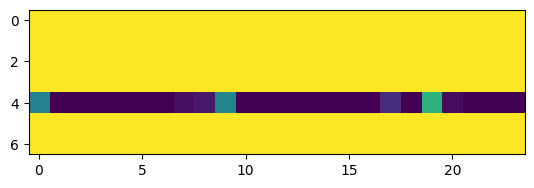

In [ ]:
plt.imshow(hwc.thermogram)

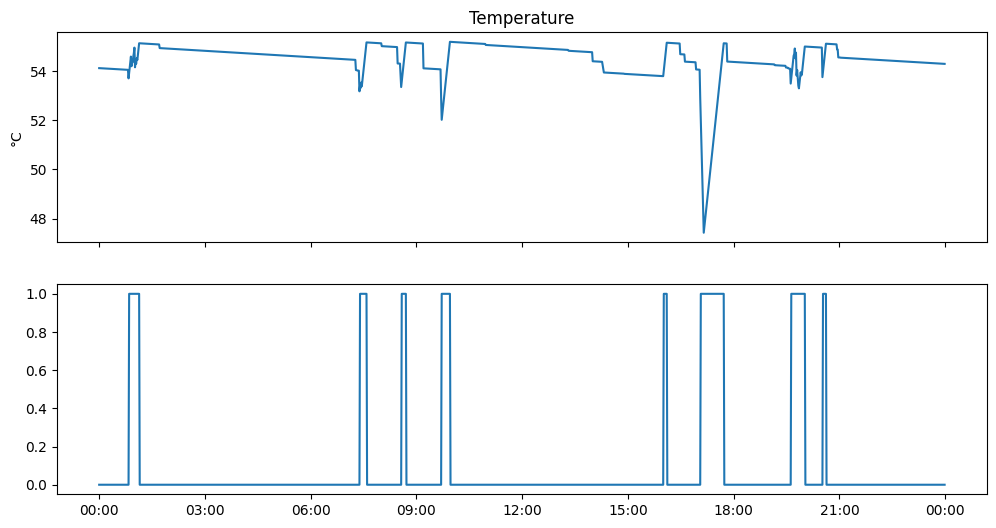

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6), sharex=True)
ax[0].plot(results.temperature)
# ax[1].plot(results['flow']*100)
ax[0].set_ylabel('°C')
ax[0].set_title('Temperature')
ax[1].plot(results['thermostat'])
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

In [ ]:
print(f'The element was on for {results.thermostat.sum()} minutes.')
print(f'Power consumption was {results.thermostat.sum()/60*hwc.element:.2f} kWh.')

The element was on for 129 minutes.
Power consumption was 6.45 kWh.


# Passive Cooling

In [ ]:
hwc = HWC(T_set=68, T_deadband=2, element=3, radius=.2, height=1.5)
results = []
for index, row in df.loc['2020-01-03'].iterrows():
  raw_flow = 0
  hwc.flow = raw_flow*(hwc.T_demand-hwc.T_cold)/(hwc.T-hwc.T_cold)
  hwc._thermostat()
  hwc.T = hwc._update_temperatures(action=0)
  results.append([index,hwc.T, hwc.thermostat, hwc.flow,row.cost])
  r,c = row.day, row.hour
  hwc.thermogram[r,c] = hwc.thermostat * 1 * hwc.Qi /60 + hwc.thermogram[r,c]*(1- 0.1)
results = pd.DataFrame(results, columns=['time','temperature','thermostat','flow','cost']).set_index('time')

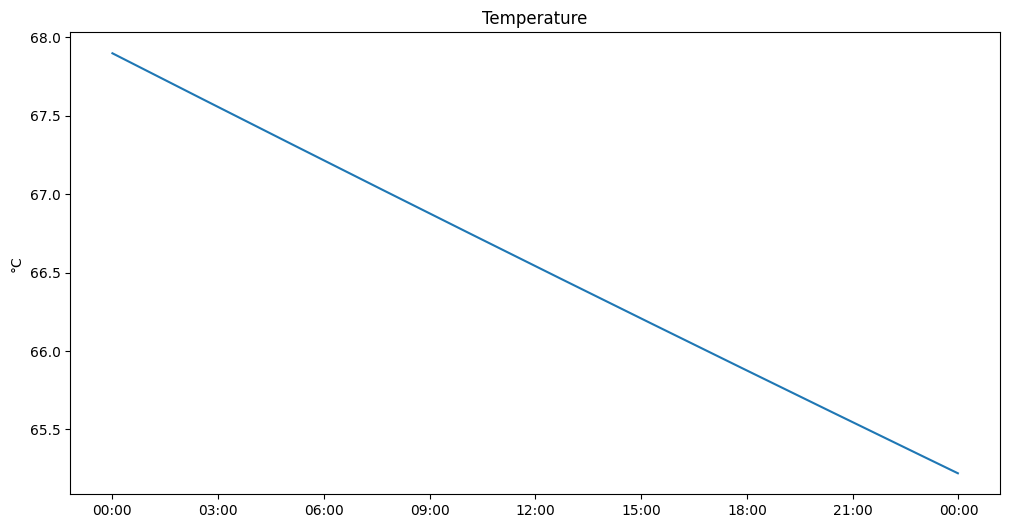

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
ax.plot(results.temperature)
ax.set_ylabel('°C')
ax.set_title('Temperature')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

<matplotlib.image.AxesImage>

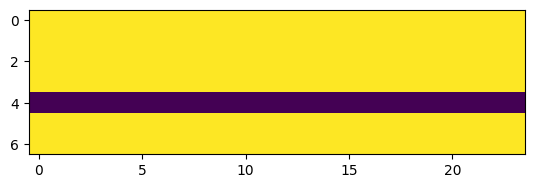

In [ ]:
plt.imshow(hwc.thermogram)

In [ ]:
print(f'The HWC volume is {int(hwc.volume*1000)} liters')
print(f'The HWC surface area is {hwc.surface_area:.2f} m2')
print(f'One day standing heat losses  : {4.128*.188*(results.temperature.max()-results.temperature.min()):.2f} kWh')

The HWC volume is 188 liters
The HWC surface area is 2.14 m2
One day standing heat losses  : 2.08 kWh
